## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense,Embedding, Dropout,Flatten, add,GRU
from gensim.models import Word2Vec
import tensorflow
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchviz import make_dot
from transformers import pipeline
from tensorflow import keras
import tensorflow as tf
import os.path
import gensim
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

In [2]:
BASE_DIR ="E:/unt/spring_2023/dl/project/Flickr8k_Dataset/Images"
WORKING_DIR = "E:/unt/spring_2023/dl/project/image_captions/image_caption_gen/flickr8k_img/working/"

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
print(model.summary())
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR)

for img_name in os.listdir(directory):
    
    img_path=os.path.join(BASE_DIR,img_name).replace("\\", "/")
    
    image = load_img(img_path, target_size=(224, 224))
    image=img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
   
    image = preprocess_input(image)
    
    feature = model.predict(image, verbose=0)
    
    image_id = img_name.split('.')[0]
    
    features[image_id] = feature


KeyboardInterrupt



In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [11]:
with open('E:/unt/spring_2023/dl/project/Flickr8k_Dataset/captions/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [13]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    
    return lsamodel

In [14]:
def tokenize_words_v1(text):
    tokenized_words=[]
    stopwrds=stopwords.words('english')
    stopwrds.remove('no')                  #include are exclude words according to the domain
    stopwrds.remove('not')
    for i in text:
        tokenizer = RegexpTokenizer(r'\w+')     #using regular expression tokenizer
        wrd_token=tokenizer.tokenize(i)         
        lemmatizer = WordNetLemmatizer()         #intializing lemmatizer
        wrd_token=[word.lower() for word in wrd_token]       #converting to lower case
        wrd_token=[lemmatizer.lemmatize(word) for word in wrd_token if word not in stopwrds] #stopword removal and lemmatization
        if not wrd_token:
            wrd_token=tokenizer.tokenize(i)
        tokenized_words.append(wrd_token)
        
    return tokenized_words

In [50]:
data=captions_doc.lower()
data = re.sub(r'[^\w\n]',' ',data)
d1=data.split("\n")
data_test_tokens=[" ".join(p.split()[2:]) for p in d1]

number_of_topics=7
words=5

doc_tokens=tokenize_words_v1(data_test_tokens)  #tokenizing the doc(ans+que)
model_lsa=create_gensim_lsa_model(doc_tokens,number_of_topics,words)

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

topics_data=model_lsa.print_topics(7,6)
data=[]
for j in topics_data:
    result = []
    #result.append(j[0])
    terms = j[1].split('+')
    # Loop over each term and split on the asterisk
    for term in terms:
        num, word = term.split('*')
        result.append((float(num),word.strip('" ')))
    
    data.append(result)



# Extract the numeric coefficients and words from the data
coeffs = []
words = []
for row in data:
    for item in row[1:]:
        coeffs.append(item[0])
        words.append(item[1])

# Convert the words to numeric vectors using one-hot encoding
vocab = list(set(words))
word_vectors = []
for word in words:
    vector = [int(word == w) for w in vocab]
    word_vectors.append(vector)
    
word_vectors=np.array(word_vectors)

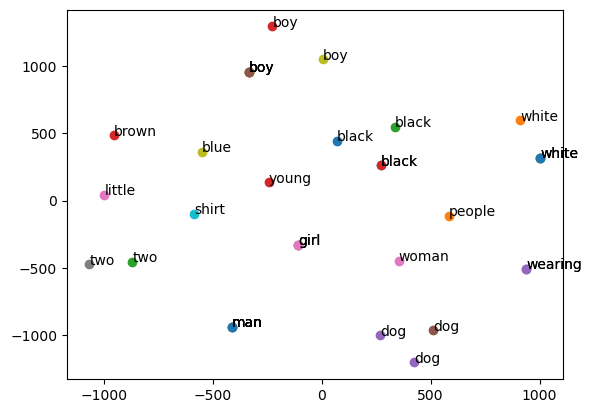

In [35]:
# Run t-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, perplexity=10, learning_rate=100)
embedding = tsne.fit_transform(word_vectors)

# Plot the results
fig, ax = plt.subplots()
for i, word in enumerate(words):
    ax.scatter(embedding[i, 0], embedding[i, 1])
    ax.annotate(word, (embedding[i, 0], embedding[i, 1]))
plt.show()

In [15]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Preprocess Text Data

In [16]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [17]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [18]:
# preprocess the text
clean(mapping)

In [19]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [20]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [21]:
len(all_captions)

40455

In [22]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [23]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [24]:
vocab_size

8313

In [25]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

## Train Test Split

In [43]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [44]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [67]:
from tensorflow import keras
import tensorflow as tf

In [62]:
class Merger_Model(Model):
    def __init__(self,vocab_size):
        super(Merger_Model,self).__init__()
        #self.input_1= Input(shape=(15,))
        self.input_1_dropout= Dropout(0.4)
        self.input_1_dense= Dense(256,activation="relu")
        
        #self.input_2=Input(shape=(400,))
        self.input_2_embed= Embedding(vocab_size,256)
        self.input_2_dropout= Dropout(0.3)
        self.input_2_GRU = GRU(256)
        
        self.merge_output= Dense(256, activation="relu")
        self.output_1= Dense(vocab_size,activation="softmax")
        
    def call(self,inputs):
        #print(inputs)
        #print(inputs[0].shape,inputs[1].shape)
        #x1=self.input_1(inputs[0])
        x1=self.input_1_dropout(inputs[0])
        x1=self.input_1_dense(x1)
        
       # x2=self.input_2(inputs[1])
        x2=self.input_2_embed(inputs[1])
        x2=self.input_2_dropout(x2)
        x2=self.input_2_GRU(x2)
        
        x3=add([x1,x2])
        x3=self.merge_output(x3)
        x3=self.output_1(x3)
        
        return x3

In [63]:
merge=Merger_Model(vocab_size)

In [194]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

opt=keras.optimizers.Adam(learning_rate=0.001)
merge.compile(loss="categorical_crossentropy", optimizer=opt)

In [196]:
history=merge.fit(generator, epochs=60, steps_per_epoch=steps, verbose=1)

Epoch 1/30
227/227 [==============================] - 329s 1s/step - loss: 2.2203
Epoch 2/30
227/227 [==============================] - 333s 1s/step - loss: 2.1795
Epoch 3/30
227/227 [==============================] - 332s 1s/step - loss: 2.1453
Epoch 4/30
227/227 [==============================] - 334s 1s/step - loss: 2.1130
Epoch 5/30
227/227 [==============================] - 326s 1s/step - loss: 2.0826
Epoch 6/30
227/227 [==============================] - 328s 1s/step - loss: 2.0554
Epoch 7/30
227/227 [==============================] - 325s 1s/step - loss: 2.0269
Epoch 8/30
227/227 [==============================] - 328s 1s/step - loss: 2.0048
Epoch 9/30
227/227 [==============================] - 353s 2s/step - loss: 1.9790
Epoch 10/30
227/227 [==============================] - 354s 2s/step - loss: 1.9582
Epoch 11/30
227/227 [==============================] - 354s 2s/step - loss: 1.9359
Epoch 12/30
227/227 [==============================] - 353s 2s/step - loss: 1.9148
Epoch 13/30
2

In [197]:
merge.save(os.path.join(os.getcwd(), "merge_model_v1"), save_format="tf")

INFO:tensorflow:Assets written to: E:\unt\spring_2023\dl\project\image_captions\image_caption_gen\flickr8k_img\merge_model_v1\assets


INFO:tensorflow:Assets written to: E:\unt\spring_2023\dl\project\image_captions\image_caption_gen\flickr8k_img\merge_model_v1\assets


In [4]:
import tensorflow as tf

model1 = tf.keras.models.load_model(os.path.join(os.getcwd(), "merge_model"))

## Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [37]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()
m,n=[],[]
for key in test:
    # get actual caption
    captions = mapping[key]
    m.append(captions)
    # predict the caption for image
    y_pred = predict_caption(model1, features[key], tokenizer, max_length) 
    n.append(y_pred)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    #print(y_pred)



In [38]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.524187
BLEU-2: 0.314509


In [39]:
from rouge import Rouge 
r = Rouge()
s=[]
for i,j in zip(m,n):
    s.append(r.get_scores(j,",".join(i)))

In [40]:
r1r,r1p,r1f=[],[],[]
r2r,r2p,r2f=[],[],[]
rlr,rlp,rlf=[],[],[]
for i in s:
    r1r.append(i[0]['rouge-1']['r'])
    r1p.append(i[0]['rouge-1']['p'])
    r1f.append(i[0]['rouge-1']['f'])
    r2r.append(i[0]['rouge-2']['r'])
    r2p.append(i[0]['rouge-2']['p'])
    r2f.append(i[0]['rouge-2']['f'])
    rlr.append(i[0]['rouge-l']['r'])
    rlp.append(i[0]['rouge-l']['p'])
    rlf.append(i[0]['rouge-l']['f'])

In [41]:
r1rs=sum(r1r)/len(r1r)
r1ps=sum(r1p)/len(r1p)
r1fs=sum(r1f)/len(r1f)
r2rs=sum(r2r)/len(r2r)
r2ps=sum(r2p)/len(r2p)
r2fs=sum(r2f)/len(r2f)
rlrs=sum(rlr)/len(rlr)
rlps=sum(rlp)/len(rlp)
rlfs=sum(rlf)/len(rlf)

In [68]:
print("Rogue-1 Scores")
print("---------------------------------------")
print(f'\tRecall = {r1rs}')
print(f'\tPrecision = {r1ps}')
print(f'\tF-1 Score = {r1fs}')
print("---------------------------------------")

print("Rogue-2 Scores")
print("---------------------------------------")
print(f'\tRecall = {r2rs}')
print(f'\tPrecision = {r2ps}')
print(f'\tF-1 Score = {r2fs}')
print("---------------------------------------")
print("Rogue-L Scores")
print("---------------------------------------")
print(f'\tRecall = {rlrs}')
print(f'\tPrecision = {rlps}')
print(f'\tF-1 Score = {rlfs}')

Rogue-1 Scores
---------------------------------------
	Recall = 0.20922659933203333
	Precision = 0.6045484910272492
	F-1 Score = 0.30625726300729933
---------------------------------------
Rogue-2 Scores
---------------------------------------
	Recall = 0.04029103021189414
	Precision = 0.17848565503134953
	F-1 Score = 0.06488682153203731
---------------------------------------
Rogue-L Scores
---------------------------------------
	Recall = 0.19274919368745888
	Precision = 0.5582046750755897
	F-1 Score = 0.2823011768045294


## Visualize the Results

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name,modelg):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    
    y_pred = predict_caption(modelg, features[image_id], tokenizer, max_length)
    
    plt.imshow(image)
    return captions,y_pred

---------------------Actual---------------------

startseq blonde child swinging on swing endseq
startseq smiling child wearing white t-shirt with stripes and skull and crossbones is swinging endseq
startseq young child in swing wearing skull and crossbones shirt endseq
startseq the blonde haired child played on the swing endseq
startseq the young girl in cartoon shirt is enjoying ride on swing endseq

---------------------Predicted---------------------
 startseq girl swinging on swing swing endseq


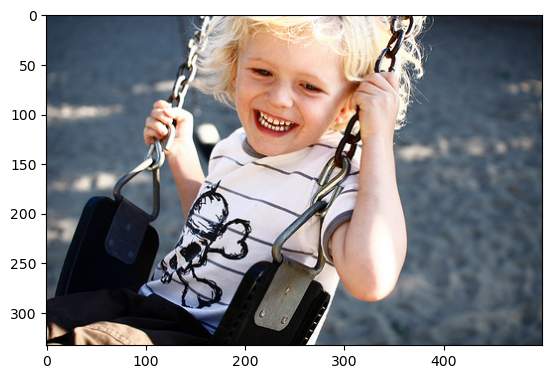

In [46]:
captions,predictions=generate_caption("2860040276_eac0aca4fc.jpg",model1)
print('---------------------Actual---------------------\n')
for caption in captions:
    print(caption)
    
print('\n---------------------Predicted---------------------\n',predictions)

---------------------Actual---------------------

startseq man wearing an orange coat speaks to another as they walk in the snow endseq
startseq mountain climbers stopping to rest on climb endseq
startseq two men in red and orange jackets leaning on poles in the snow endseq
startseq two men with snow equipment stare into the distance endseq
startseq two mountaineers are looking ahead on snowy trail endseq

---------------------Predicted---------------------
 startseq man wearing red jacket and black jacket is wearing red jacket and black jacket and black jacket and black jacket is wearing red jacket and black jacket and black jacket and


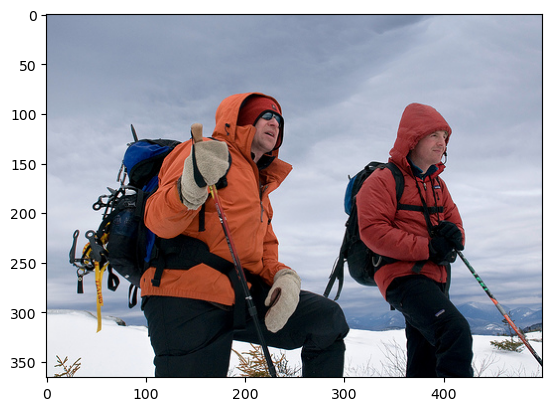

In [47]:
captions,predictions=generate_caption("2272823323_3b7291cd47.jpg",model1)
print('---------------------Actual---------------------\n')
for caption in captions:
    print(caption)
    
print('\n---------------------Predicted---------------------\n',predictions)

---------------------Actual---------------------

startseq two babies look up while they are playing in playpen with lot of balls endseq
startseq "two boys in tent-like area endseq
startseq two children look up endseq
startseq two kids are in pen playing with colorful balls endseq
startseq two young children play with colored balls endseq

---------------------Predicted---------------------
 startseq little boy is playing with plastic toy endseq


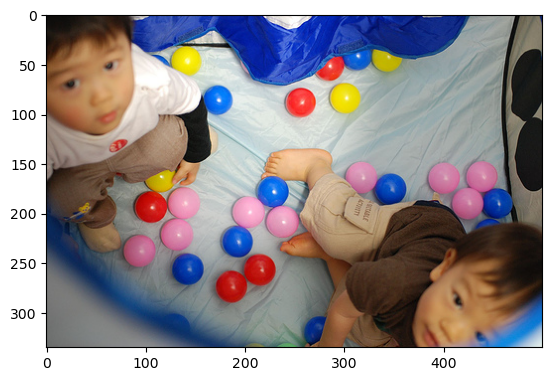

In [48]:
captions,predictions=generate_caption("820169182_f5e78d7d19.jpg",model1)
print('---------------------Actual---------------------\n')
for caption in captions:
    print(caption)
    
print('\n---------------------Predicted---------------------\n',predictions)


## Image similarity

In [51]:
def tokenize_words(text):
    tokenized_words,vocab=[],[]
    stopwrds=stopwords.words('english')
    stopwrds.remove('no')                  #include are exclude words according to the domain
    stopwrds.remove('not')
    for i in text:
        tokenizer = RegexpTokenizer(r'\w+')     #using regular expression tokenizer
        wrd_token=tokenizer.tokenize(i)         
        tokenized_words.append(wrd_token)
        vocab.extend(wrd_token)
    return tokenized_words, vocab

doc_tokens_w2v,vocab=tokenize_words(data_test_tokens)  #tokenizing the doc(ans+que)
model_w2v=Word2Vec(doc_tokens_w2v,min_count=1,window=4) 

In [52]:
def get_img_vector(caption,vocab,model_doc):
    caption=caption.replace("startseq","").replace("endseq","").split()
    vector=0
    for i in caption:
        if i in vocab:
            vector+=model_doc.wv[i]

    img_vector=np.reshape(vector,(1,-1))
    return img_vector

In [53]:
def compare_images(img1,img2,embed_model,vocab,pred_model):
    
    
    
    img1_path = os.path.join(BASE_DIR, img1)
    img1_plt = Image.open(img1_path)
    img2_path = os.path.join(BASE_DIR, img2)
    img2_plt = Image.open(img2_path)
    
    fig=plt.figure(figsize=(20,10))
    fig.add_subplot(1,2,1)
    plt.imshow(img1_plt)
    fig.add_subplot(1,2,2)
    plt.imshow(img2_plt) 
    
    img1_caption,img1_pred_caption=generate_caption(img1,pred_model)
    img1_pred_caption = img1_pred_caption.replace("startseq", "").replace("endseq", "")
    print("Image 1 Caption \n\t",img1_pred_caption,"\n")
    
    img2_caption,img2_pred_caption=generate_caption(img2,pred_model)
    img2_pred_caption = img2_pred_caption.replace("startseq", "").replace("endseq", "")
    print("Image 2 Caption \n\t",img2_pred_caption,"\n")
    
    img1_vector=get_img_vector(img1_pred_caption,vocab,embed_model)
    img2_vector=get_img_vector(img2_pred_caption,vocab,embed_model)
    
    img_sim=cosine_similarity(img1_vector,img1_vector)[0][0]
    
    print(f'Images have a similarity = {img_sim}')
    

Image 1 Caption 
	  two children are playing in the water  

Image 2 Caption 
	  man wearing red jacket and black jacket is wearing red jacket and black jacket and black jacket and black jacket is wearing red jacket and black jacket and black jacket and 

Images have a similarity = 0.9999998807907104


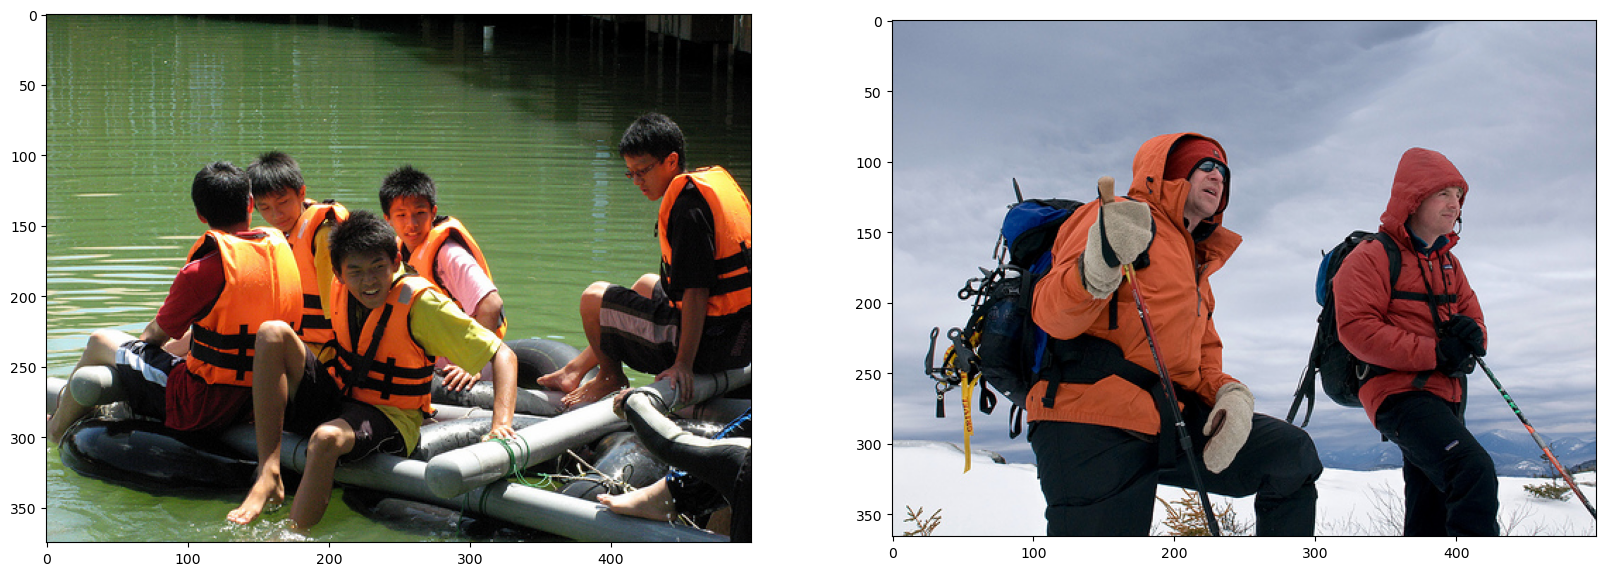

In [57]:
img1="2461631708_decc5b8c87.jpg"
img2="2272823323_3b7291cd47.jpg"
compare_images(img1,img2,model_w2v,vocab,model1)

In [55]:
def get_image_sentiment(img1,pred_model):
    
    model_bert="distilbert-base-uncased-finetuned-sst-2-english"
    classifier=pipeline("sentiment-analysis",model=model_bert)
    
    img1_caption,img1_pred_caption=generate_caption(img1,pred_model)
    img1_pred_caption = img1_pred_caption.replace("startseq", "").replace("endseq", "")
    print("Image  Caption \n\t",img1_pred_caption,"\n")
    
    res= classifier(img1_pred_caption)
    sentiment=res[0]['label']
    score=res[0]['score']
    print(f'Sentiment = {sentiment} \nScore = {score}')
    

Image  Caption 
	  girl swinging on swing swing  

Sentiment = POSITIVE 
Score = 0.9993365406990051


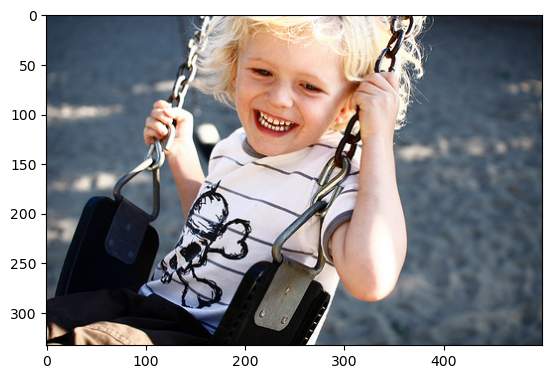

In [58]:
get_image_sentiment("2860040276_eac0aca4fc.jpg",model1)